In [22]:
using Pkg
pkg_folder = "../"
Pkg.activate(pkg_folder)

import Markdown; Base.showable(::MIME"text/markdown", ::Markdown.MD) = false # to make sth like """?replace"""  works for vscode backend, remember to choose Jupyter kernel
include(pkg_folder*"src/initialize.jl")

@show Threads.nthreads() # check number of threads

  Activating 

Threads.nthreads() = 1

project at `~/Documents/GitHub/Bnc_julia`


1

In [23]:
q_sym = [:Atot, :Btot]
K_sym = [:Kab, :Kaa, :Kbb]
x_sym = [:A, :B, :AB, :AA, :BB]

N = [1 1 -1 0 0;
     2 0 0 -1 0;
     0 2 0 0 -1;]

model = Bnc(N=N, x_sym=x_sym, q_sym=q_sym, K_sym=K_sym)

find_all_vertices!(model)
summary(model)
show_conservation(model)

---------------------Start finding all vertices, it may takes a while.--------------------
Finished, with 9 vertices found and 9 asymptotic vertices.

-------------Start calculating nullity for each vertex, it also takes a while.------------
1.Building Nρ_inv cache in parallel...
2.Calculating nullity for each vertex in parallel...
3.Storing all vertices information...
Done.
----------Binding Network Summary:-------------
Number of species (n): 5
Number of conserved quantities (d): 2
Number of reactions (r): 3
L matrix: [1 0 1 2 0; 0 1 1 0 2]
N matrix: [1 1 -1 0 0; 2 0 0 -1 0; 0 2 0 0 -1]
Direction of binding reactions: backward
Catalysis involved: No
Regimes constructed: Yes
Number of regimes: 9
  - Invertible + Asymptotic: 8
  - Singular +  Asymptotic: 1
  - Invertible +  Non-Asymptotic: 0
  - Singular +  Non-Asymptotic: 0
-----------------------------------------------


2-element Vector{Equation}:
 Atot ~ A + 2AA + AB
 Btot ~ AB + B + 2BB

----------------Start calculating vertices neighbor graph, It may takes a while.----------------
Done.

-------Start calculating vertices neighbor graph with qK change dir, It may takes a while.------------
Done.



┌ Info: Number of polyhedra to calc volume: 8
└ @ Main /Users/wuxiaoyu/Documents/GitHub/Bnc_julia/src/volume_calc.jl:17
┌ Info: All regimes converged after 1800000 samples.
└ @ Main /Users/wuxiaoyu/Documents/GitHub/Bnc_julia/src/volume_calc.jl:55
┌ Info: Total samples: 1800000, Elapsed: 1.23 s
└ @ Main /Users/wuxiaoyu/Documents/GitHub/Bnc_julia/src/volume_calc.jl:121


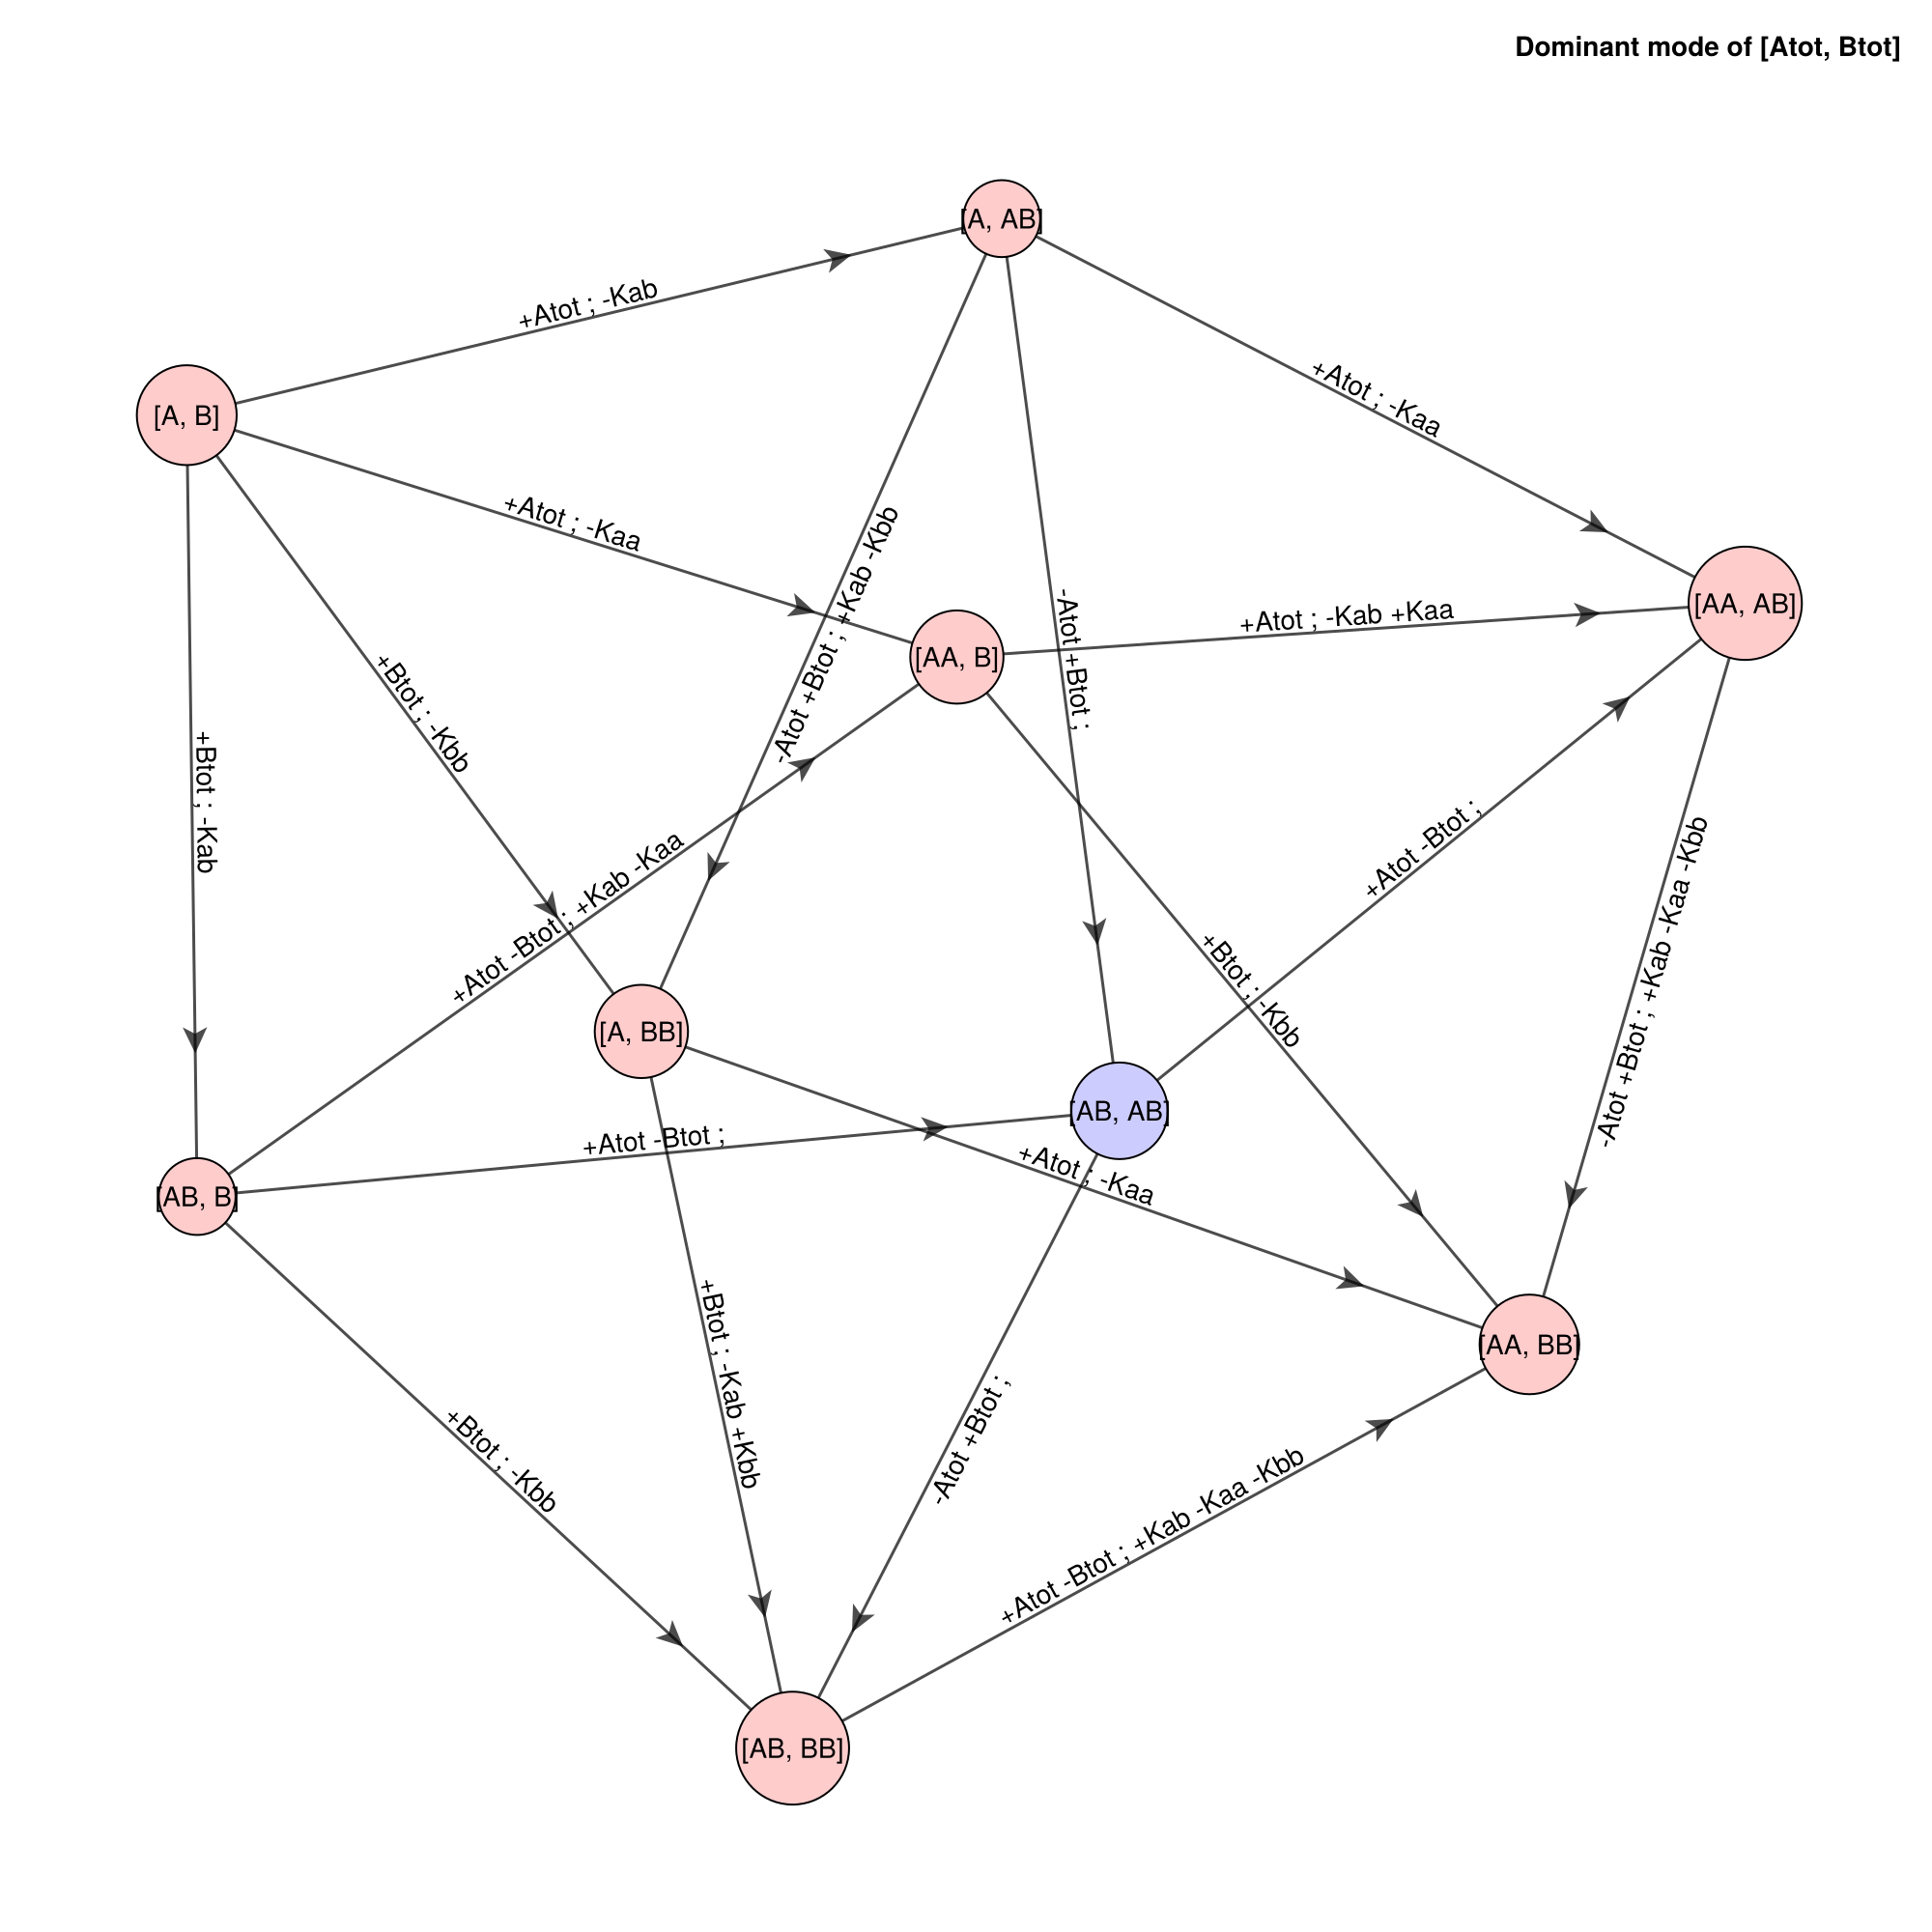

CairoMakie.Screen{IMAGE}


In [24]:
f,ax,p = draw_vertices_neighbor_graph(model)
# add_vertices_idx!(ax, p)
display(f)

In [31]:
grh = SISO_graph(model, :Atot)
summary_path(grh, :AA) |> render_path

┌ Info: sources: [4, 6, 3, 1]
└ @ Main /Users/wuxiaoyu/Documents/GitHub/Bnc_julia/src/regime_graphs.jl:232
┌ Info: sinks: [8]
└ @ Main /Users/wuxiaoyu/Documents/GitHub/Bnc_julia/src/regime_graphs.jl:233
┌ Info: Number of polyhedra to calc volume: 10
└ @ Main /Users/wuxiaoyu/Documents/GitHub/Bnc_julia/src/volume_calc.jl:17


Path [2, 4, 7, 10]    2 → 1 → 1                     	  Volume: 0.4998 ± 0.0025
Path [6, 9]           2 → Inf → 1                   	  Volume: 0.1876 ± 0.0009
Path [1, 3]           2 → 2 → 1                     	  Volume: 0.1669 ± 0.0008
Path [5, 8]           2 → Inf → 2 → 1               	  Volume: 0.1456 ± 0.0007


┌ Info: All regimes converged after 7300000 samples.
└ @ Main /Users/wuxiaoyu/Documents/GitHub/Bnc_julia/src/volume_calc.jl:55
┌ Info: Total samples: 7300000, Elapsed: 3.78 s
└ @ Main /Users/wuxiaoyu/Documents/GitHub/Bnc_julia/src/volume_calc.jl:121


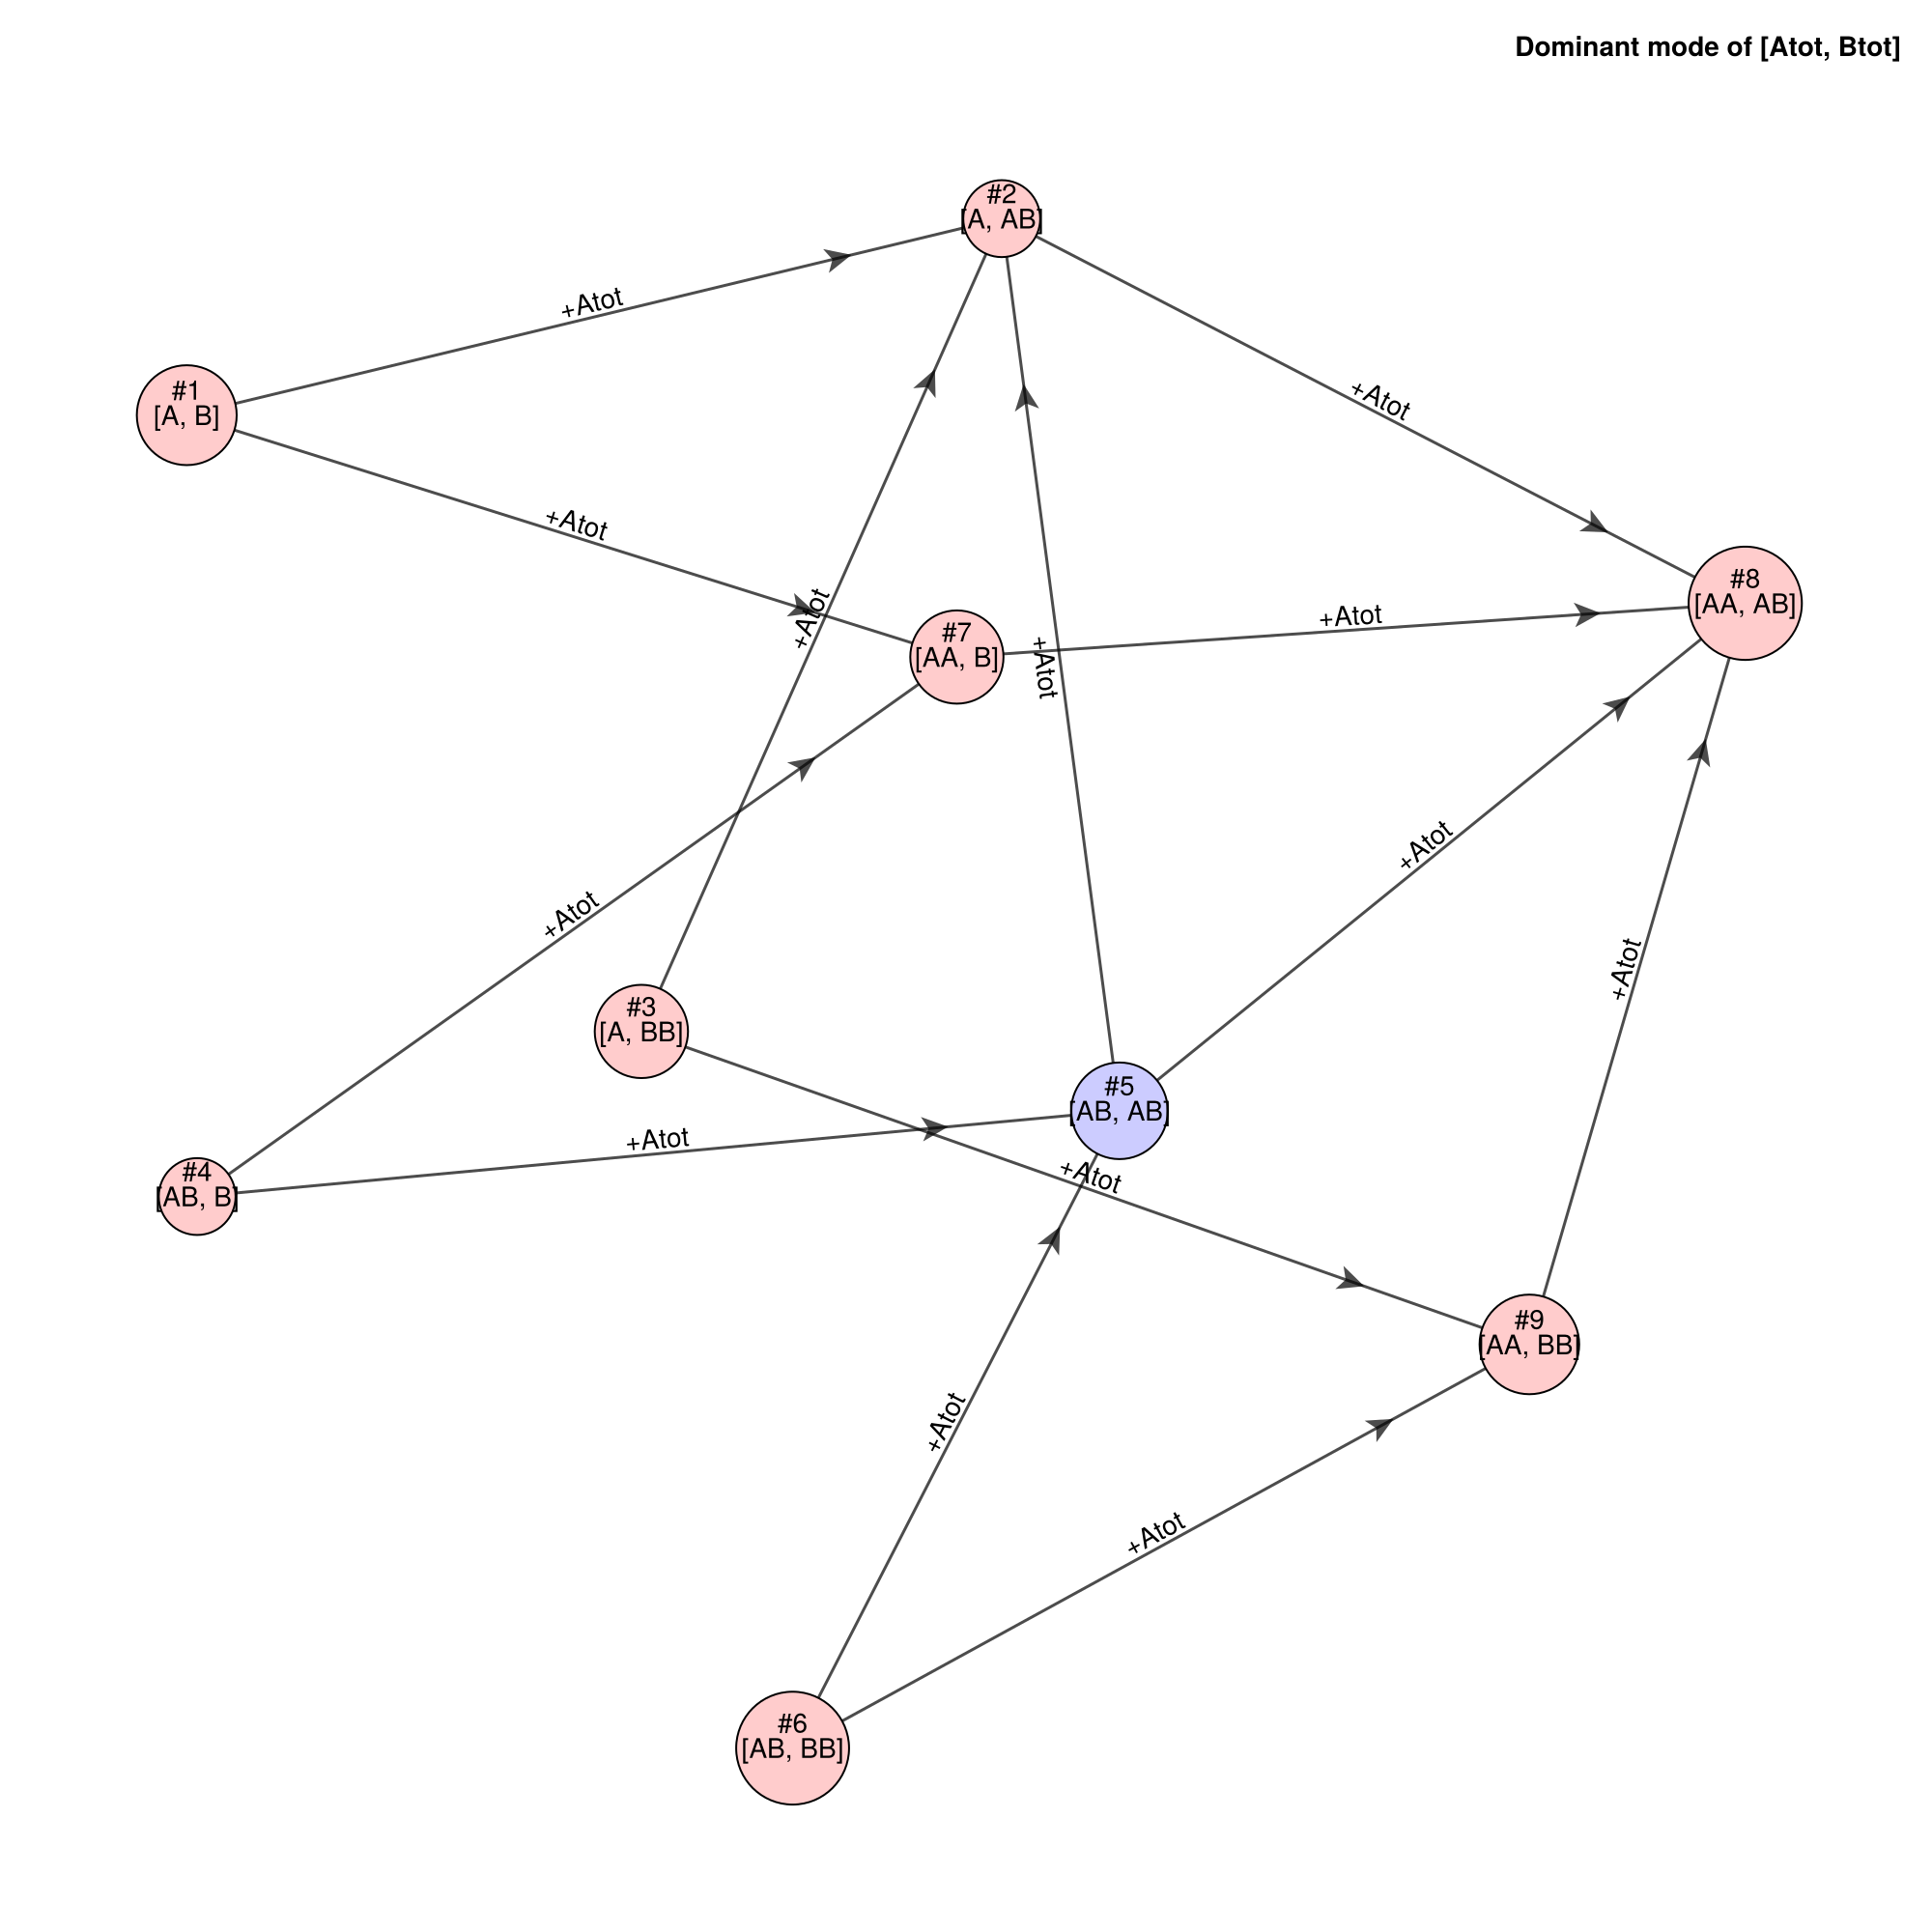

CairoMakie.Screen{IMAGE}


In [29]:
f, ax, p = draw_vertices_neighbor_graph(grh)
add_vertices_idx!(ax, p)
display(f)

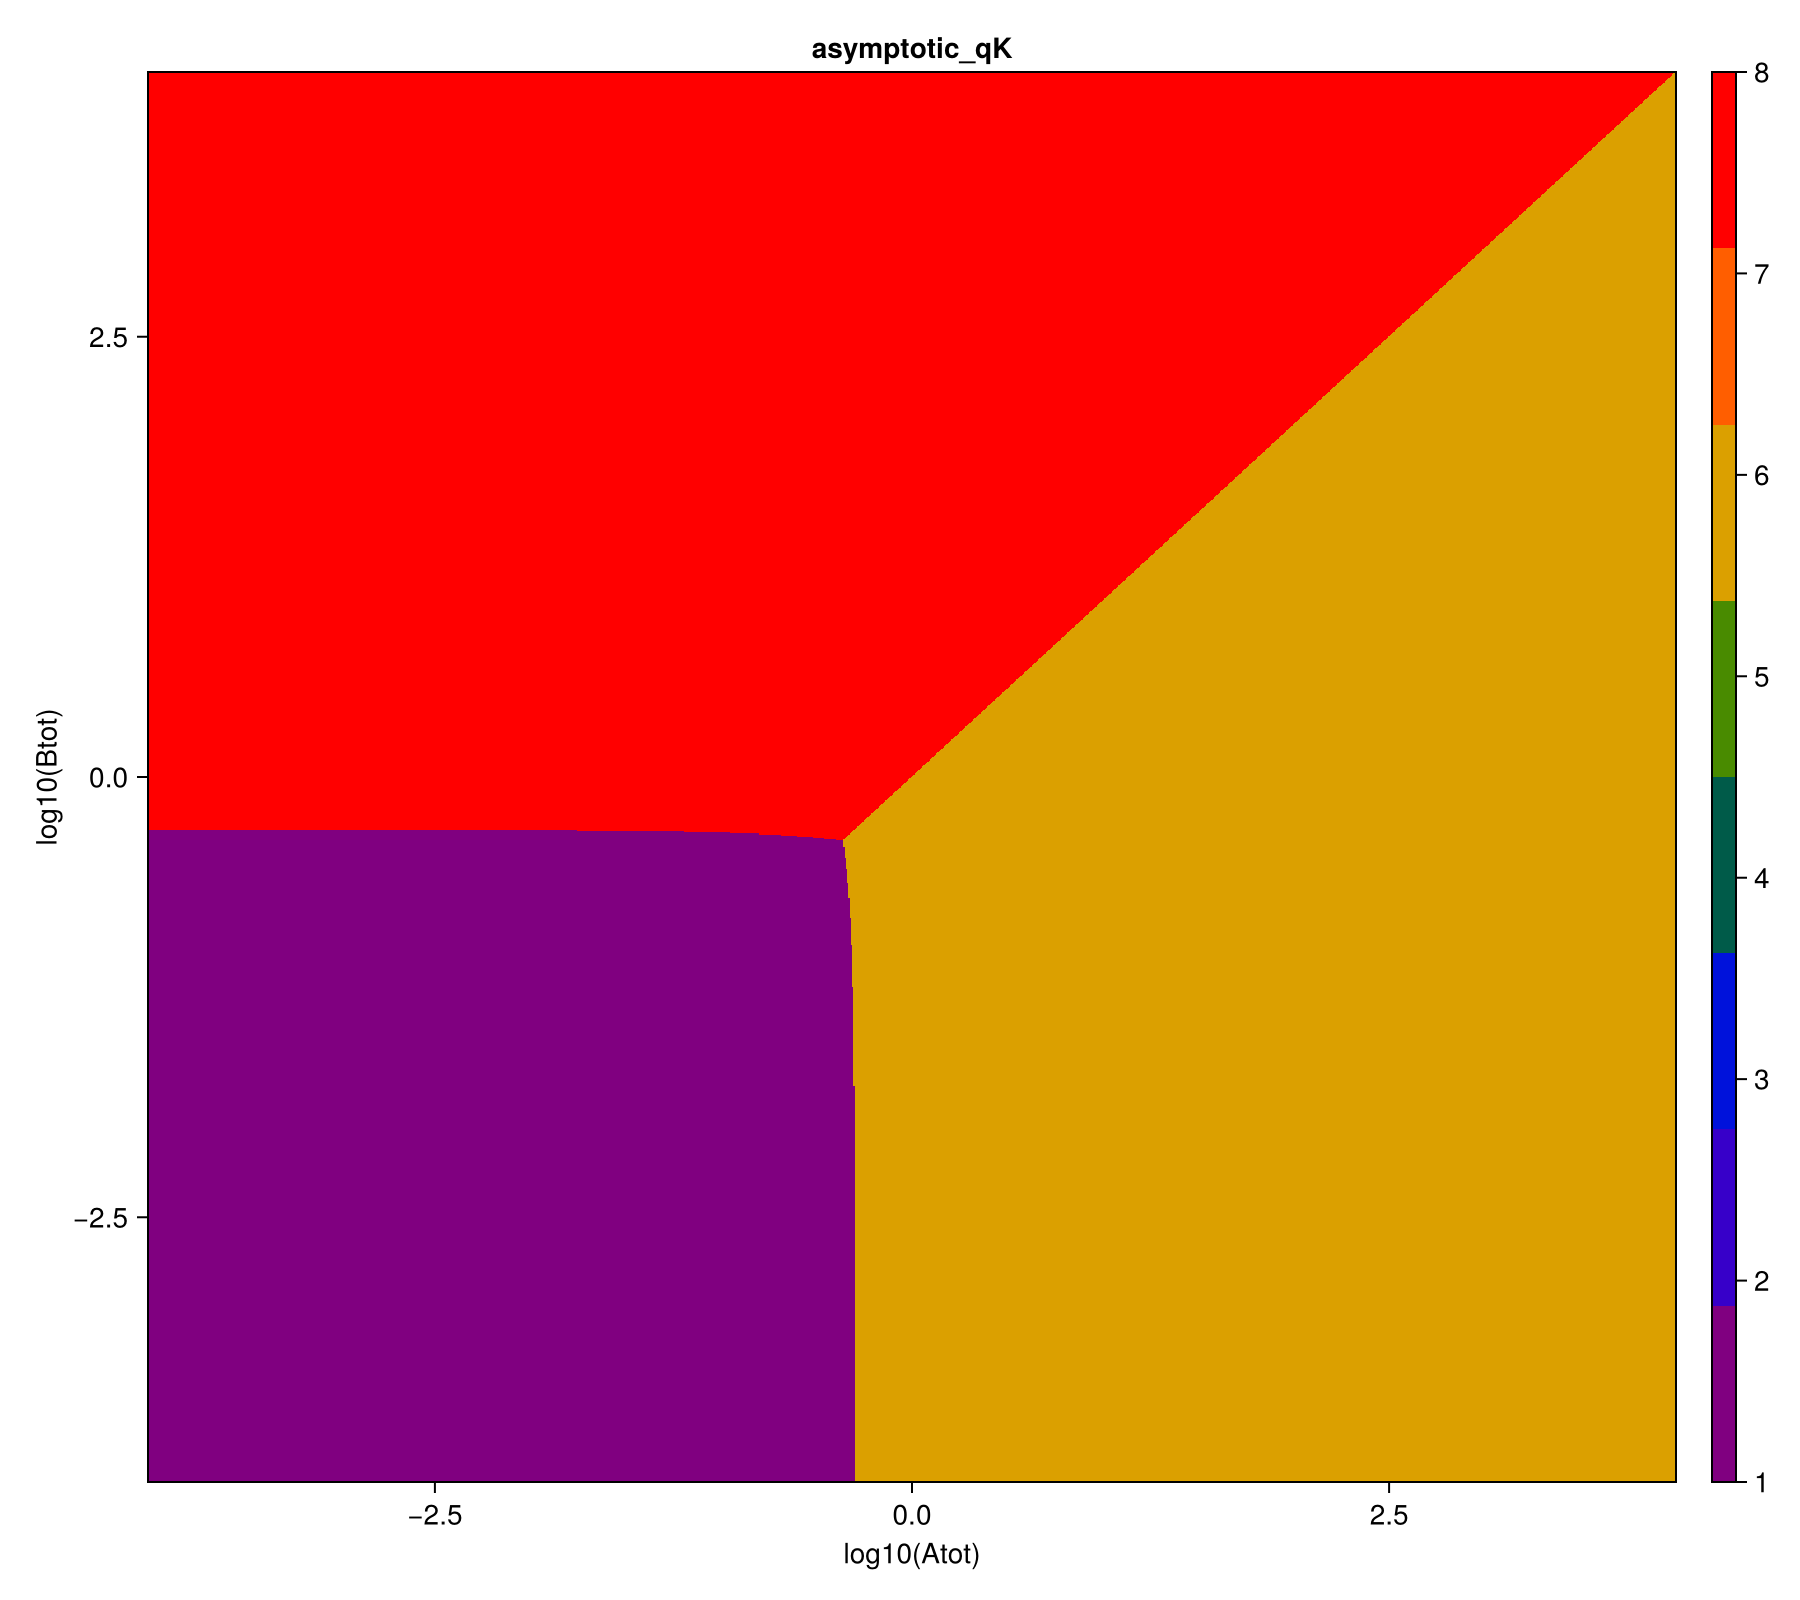

CairoMakie.Screen{IMAGE}


In [34]:
using CairoMakie
points = 1200  # reduce if runtime is high
logA_rg = range(-4, 4, length=points)  # log10(Atot)
logB_rg = range(-4, 4, length=points)  # log10(Btot)
logKab = 0.0; logKaa = 0.0; logKbb = 0.0  # K values in log10 space
regime_idx = Matrix{Int}(undef, points, points)
for i in 1:points
    for j in 1:points
        logqK = [logA_rg[i], logB_rg[j], logKab, logKaa, logKbb]  # must be a Vector, not a tuple
        logx = qK2x(model, logqK; input_logspace=true, output_logspace=true, use_vtx=true)
        rgm = assign_vertex_qK(model; x=logx, input_logspace=true, asymptotic=true)
        regime_idx[i, j] = get_idx(model, rgm)
    end
end

crange = extrema(regime_idx)
cmap = cgrad(:rainbow, crange[2] - crange[1] + 1, categorical=true)
f = Figure(size=(900, 800))
ax = Axis(f[1, 1], title="asymptotic_qK", xlabel="log10(Atot)", ylabel="log10(Btot)")
heatmap!(ax, logA_rg, logB_rg, regime_idx'; colormap=cmap, colorrange=crange)
Colorbar(f[1, 2], colormap=cmap, colorrange=crange)
display(f)